In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from tensorflow.keras import models, layers

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
import time

2025-04-22 04:30:43.571800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745321443.599847  254018 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745321443.608267  254018 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 04:30:43.639538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data():
    df = pd.read_csv('cluster_data/train_workloads_final_75_clusters.csv')
    
    # Assuming `df` is your DataFrame
    feature_cols = [col for col in df.columns if col.startswith('cluster_')]

    print(feature_cols)

    target_col = ['actual']
    
    X = df[feature_cols]
    y = df[target_col]
    
    print('X.shape: ', X.shape)
    print('y.shape: ', y.shape)
    
    return X.values, y.values

def load_test_data():
    df = pd.read_csv('cluster_data/test_workloads_final_75_clusters.csv')
  
    # Assuming `df` is your DataFrame
    feature_cols = [col for col in df.columns if col.startswith('cluster_')]
    print(feature_cols)

    
    target_cols = ['db2', 'actual']
    
    X = df[feature_cols]
    Y = df[target_cols]
    
    return X, Y

def my_validation_curve(estimator_name, estimator, param_name, param_range):
    train_scores, valid_scores = validation_curve(estimator, X, y, param_name=param_name,
        param_range=param_range, cv=10, scoring="neg_mean_squared_error",
    )

    train_scores = np.sqrt(np.abs(train_scores))
    valid_scores = np.sqrt(np.abs(valid_scores))
    
    print(len(train_scores))
    print(len(valid_scores))

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    
    title_str = "Validation Curve with " + estimator_name
    plt.title(title_str)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.plot(param_range, train_scores_mean, label="train rmse")
    plt.plot(param_range, valid_scores_mean, label="validation rmse")

    plt.legend(loc='lower right')
    plt.show()
    
    train_rmse = [round(elem, 2) for elem in train_scores_mean]
    valid_rmse = [round(elem, 2) for elem in valid_scores_mean]
    
    df_scores = pd.DataFrame({'param': param_range, 'train_rmse': train_rmse, 'valid_rmse': valid_rmse})
    print(df_scores)
    
def cross_validate(model):
    # Load data
    X, y = load_data()
    train_data = X.copy()
    train_targets = y.copy()

    k = 10
    num_val_samples = len(train_data) // k
    all_train_scores = []
    all_scores = []
    
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                             train_data[(i + 1) * num_val_samples:]], axis=0)
        
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                                train_targets[(i + 1) * num_val_samples:]], axis=0)

        model.fit(partial_train_data, partial_train_targets)
    
        train_mse = mean_squared_error(partial_train_targets, model.predict(partial_train_data))
        val_mse = mean_squared_error(val_targets, model.predict(val_data))
    
        all_train_scores.append(train_mse)
        all_scores.append(val_mse)
    
    print('train rmse ', np.sqrt(np.mean(all_train_scores)))
    print('validation rmse ', np.sqrt(np.mean(all_scores)))

In [3]:
# Load data
X, y = load_data()

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

# Ridge Cross-validate

In [4]:
ridge = Ridge(
        fit_intercept=True, 
        solver='lsqr',
        alpha = 1.0,
        random_state=42)

cross_validate(ridge)
ridge.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

Ridge(random_state=42, solver='lsqr')

# Decision Tree Regression - Tuning max_features

In [5]:
tree = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=0.23,
    random_state=33,
)

cross_validate(tree)

tree.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.23, min_samples_split=4,
                      random_state=33)

# Forest final model - using tuned HP from AutoAI

In [6]:
forest = RandomForestRegressor(
    max_depth=5,
    max_features=0.6109469920813564,
    min_samples_leaf=4,
    min_samples_split=5,
    n_estimators=17,
    #n_jobs=CPU_NUMBER,
    random_state=33,
)

cross_validate(forest)

forest.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed

Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  243.58903509363964
validation rmse  300.1222419872385


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed

RandomForestRegressor(max_depth=5, max_features=0.6109469920813564,
                      min_samples_leaf=4, min_samples_split=5, n_estimators=17,
                      random_state=33)

# XGB Regressor 

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Define hyperparameter search space
param_grid = {
    "n_estimators": [100, 300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 9],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.5, 0.7, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.7, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 1, 10],
    "reg_lambda": [0, 0.1, 1, 10],
    "gamma": [0, 0.1, 0.5, 1],
}

# Initialize base model with improved defaults
xgb_regressor = XGBRegressor(
    objective="reg:squarederror",
    booster="gbtree",
    tree_method="hist",  # Faster training for large data
    n_jobs=-1,  # Use all CPU cores
    random_state=33,
    verbosity=1,
)

# Perform Randomized Search Cross Validation
random_search = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=20,  # Number of random samples
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=33,
    n_jobs=-1,
)

# Run hyperparameter search
random_search.fit(X, y)

# Assign the best model to xgb_regressor (keeping reference)
xgb_regressor = random_search.best_estimator_

# Print the best hyperparameters
print("Best Parameters:", random_search.best_params_)

# Cross-validate best model
cross_validate(xgb_regressor)

# Train best model on full dataset
xgb_regressor.fit(X, y)

# Now xgb_regressor holds the best-performing model


Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'c

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

# Deep Neural Network (DNN)

In [8]:
dnn_model = dnn_model = MLPRegressor(max_iter=100,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Processing fold #1


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2
Processing fold #3


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Processing fold #4
Processing fold #5


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Processing fold #9


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  210.15149407019285
validation rmse  404.2161588348189


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=100,
             random_state=6, solver='lbfgs')

# DNN - solver='lbfgs'

In [9]:
dnn_model = dnn_model = MLPRegressor(max_iter=100,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #1


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2
Processing fold #3


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Processing fold #4
Processing fold #5


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Processing fold #9


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  210.15149407019285
validation rmse  404.2161588348189


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=100,
             random_state=6, solver='lbfgs')

# DNN - epochs = 150

In [10]:
dnn_model = dnn_model = MLPRegressor(max_iter=150,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #9


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  210.15138623447015
validation rmse  404.1440689171575


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=150,
             random_state=6, solver='lbfgs')

# DNN - activation=tanh

In [11]:
dnn_model = dnn_model = MLPRegressor(max_iter=150,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #1


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #9


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  210.15138623447015
validation rmse  404.1440689171575


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=150,
             random_state=6, solver='lbfgs')

# DNN - Relu

In [12]:
dnn_model = dnn_model = MLPRegressor(max_iter=100,
                     alpha=0.001,
                     #activation='identity',
                     activation='relu',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Processing fold #1


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #9


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  0.19545688206742393
validation rmse  402.47577384900154


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0.001, hidden_layer_sizes=(48, 39, 27, 16, 7, 5),
             max_iter=100, random_state=6, solver='lbfgs')

# All Models Summary

In [13]:
models = [ridge, tree, forest, xgb_regressor, dnn_model]

In [14]:
X_test, Y_test = load_test_data()

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0', 'cluster_10.0', 'cluster_11.0', 'cluster_12.0', 'cluster_13.0', 'cluster_14.0', 'cluster_15.0', 'cluster_16.0', 'cluster_17.0', 'cluster_18.0', 'cluster_19.0', 'cluster_20.0', 'cluster_21.0', 'cluster_22.0', 'cluster_23.0', 'cluster_24.0', 'cluster_25.0', 'cluster_26.0', 'cluster_27.0', 'cluster_28.0', 'cluster_29.0', 'cluster_30.0', 'cluster_31.0', 'cluster_32.0', 'cluster_33.0', 'cluster_34.0', 'cluster_35.0', 'cluster_36.0', 'cluster_37.0', 'cluster_38.0', 'cluster_39.0', 'cluster_40.0', 'cluster_41.0', 'cluster_42.0', 'cluster_43.0', 'cluster_44.0', 'cluster_45.0', 'cluster_46.0', 'cluster_47.0', 'cluster_48.0', 'cluster_49.0', 'cluster_50.0', 'cluster_51.0', 'cluster_52.0', 'cluster_53.0', 'cluster_54.0', 'cluster_55.0', 'cluster_56.0', 'cluster_57.0', 'cluster_58.0', 'cluster_59.0', 'cluster_60.0', 'cluster_61.0', 'cluster_62.0', '

In [15]:
X_test.shape

(46, 75)

In [16]:
Y_test.shape

(46, 2)

## Computing Inference Latency

In [17]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    tree.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

tree_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('tree: ', tree_time, ' μs')

tree:  430.9  μs


In [18]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    forest.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

forest_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('forest: ', forest_time, ' μs')

forest:  1826.4  μs


In [19]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    xgb_regressor.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

xgb_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('xgb: ', xgb_time, ' μs')

xgb:  2086.6  μs


In [20]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    ridge.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

ridge_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('ridge: ', ridge_time, ' μs')

ridge:  171.7  μs


In [21]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    dnn_model.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

dnn_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('dnn: ', dnn_time, ' μs')

dnn:  228.7  μs


## Generating Predictions

In [22]:
Y_test['tree'] = tree.predict(X_test.values)
Y_test['forest'] = forest.predict(X_test.values)
Y_test['xgb'] = xgb_regressor.predict(X_test.values)
Y_test['ridge'] = ridge.predict(X_test.values)
Y_test['dnn'] = dnn_model.predict(X_test.values)

In [23]:
Y_test.head()

,db2,actual,tree,forest,xgb,ridge,dnn
0,1551.520,1398.288,1634.836333,1645.272374,1724.617188,1733.496986,1855.514702
1,2114.152,2015.368,1634.836333,1571.068812,1624.184692,1636.737869,1671.674444
2,1938.348,1801.760,1634.836333,1645.272374,1727.903442,1666.190634,1661.415912
3,1934.232,1903.480,1634.836333,1627.673050,1677.604736,1627.616935,1745.218803
4,2096.508,2107.108,1536.196128,1583.910820,1640.336670,1760.063398,1880.641243


In [24]:
Y_test = Y_test[['actual', 'db2', 'tree', 'forest', 'xgb', 'ridge', 'dnn']]

In [25]:
from sklearn.metrics import mean_squared_error

def rmse(Y):
    cols = Y.columns.values[1:]
    rmse_dict = {}
    
    for col in cols:
        rmse = np.round(np.sqrt(mean_squared_error(Y['actual'].values, Y[col].values)))
        rmse_dict[col] = rmse
    
    return rmse_dict

In [26]:
rmse(Y_test)

{'db2': 168.0,
 'tree': 282.0,
 'forest': 280.0,
 'xgb': 271.0,
 'ridge': 420.0,
 'dnn': 499.0}

In [27]:
print('TEST RMSE')
rmse(Y_test)

TEST RMSE


{'db2': 168.0,
 'tree': 282.0,
 'forest': 280.0,
 'xgb': 271.0,
 'ridge': 420.0,
 'dnn': 499.0}

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_residuals(Y):
    first_col = Y.columns[0]
    cols = Y.columns[1:]
    df_residuals = pd.DataFrame(columns=cols)

    for col in cols:
        df_residuals[col] = Y[col] - Y[first_col]
        
    return df_residuals

def box_plot(Y):
    df_residuals = calculate_residuals(Y)
    sns.set_style("whitegrid", {'axes.grid' : False})
    f = plt.figure(figsize=[10,3])
    ax = f.add_subplot(111)
    sns.boxplot(data=df_residuals, ax=ax, showfliers = True, orient="h")
    ax.set_xlabel(xlabel=box_plot_title,fontsize=13)
    #plt.tick_params(axis='x',labeltop='on', labelbottom='on')
    #ax.xaxis.set_ticks_position('both')
    #ax.set_yticks(yticks_new)
    #plt.setp(ax.get_yticklabels(), rotation=45)
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

    plt.rc('font', **font)
    
    f.tight_layout()
    
    plt.savefig('job_workload_boxplot.png', dpi=150)

In [29]:
box_plot_title = 'Memory Estimation Error (MB)'

BOX PLOT


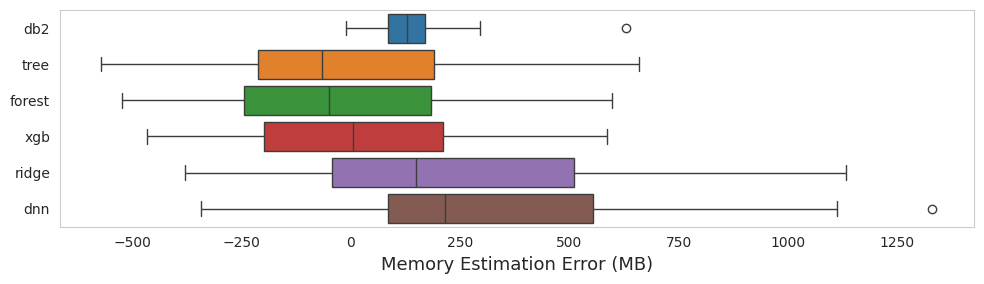

In [30]:
print('BOX PLOT')
box_plot(Y_test)

In [31]:
residuals = calculate_residuals(Y_test)

In [32]:
np.percentile(residuals['db2'], [25, 75])

array([ 83.754, 169.279])

In [33]:
np.percentile(residuals['ridge'], [25, 75])

array([-43.02597162, 510.81404731])

In [34]:
np.percentile(residuals['tree'], [25, 75])

array([-213.44766667,  190.19233333])

In [35]:
np.percentile(residuals['forest'], [25, 75])

array([-244.44514602,  182.21104998])

In [36]:
np.percentile(residuals['xgb'], [25, 75])

array([-198.62851025,  209.67780786])

In [37]:
np.percentile(residuals['dnn'], [25, 75])

array([ 84.49211994, 553.39547023])

In [38]:
np.mean(Y_test['actual'])

1631.7674782608697

In [39]:
Y_test.head()

,actual,db2,tree,forest,xgb,ridge,dnn
0,1398.288,1551.520,1634.836333,1645.272374,1724.617188,1733.496986,1855.514702
1,2015.368,2114.152,1634.836333,1571.068812,1624.184692,1636.737869,1671.674444
2,1801.760,1938.348,1634.836333,1645.272374,1727.903442,1666.190634,1661.415912
3,1903.480,1934.232,1634.836333,1627.673050,1677.604736,1627.616935,1745.218803
4,2107.108,2096.508,1536.196128,1583.910820,1640.336670,1760.063398,1880.641243


In [40]:
np.mean(Y_test)

1727.0925803911068

# Models size

In [41]:
import sys
import pickle

In [42]:
# size of the ridge model
p = pickle.dumps(ridge)
print('Ridge:', sys.getsizeof(p) / 1024)

# size of the tree model
p = pickle.dumps(tree)
print('Decision Tree:', sys.getsizeof(p) / 1024)

# size of the forest model
p = pickle.dumps(forest)
print('Random Forest:', sys.getsizeof(p) / 1024)

# size of the xgboost model
p = pickle.dumps(xgb_regressor)
print('XGBoost:', sys.getsizeof(p) / 1024)

# size of the dnn model
p = pickle.dumps(dnn_model)
print('DNN:', sys.getsizeof(p) / 1024)

Ridge: 1.1171875
Decision Tree: 1.4150390625
Random Forest: 31.0615234375
XGBoost: 326.62109375
DNN: 60.849609375


# Training Time

In [43]:
latency_sum = 0

for i in range(5):
    time_start = time.time()
    ridge.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('ridge training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    tree.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('tree training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    forest.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('forest training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    xgb_regressor.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('xgb training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    dnn_model.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('dnn training time: ', train_time, ' ms')

ridge training time:  13.1  ms
tree training time:  2.0  ms
forest training time:  37.8  ms


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed

xgb training time:  143.5  ms


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

dnn training time:  347.9  ms


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [44]:
calculate_residuals(Y_test).to_csv('job-workload-residuals.csv')